**Katie Chen <br>
INFO 370 <br>
3/2/2019**

# Predicting Dengue Fever Cases
In this report, we will predict the number of dengue fever cases using dataset from [Drivendata: Predicting Disease Speed](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/80/). Dengue fever is transmitted between humans by Aedes aegypti mosquitos. Since Aedes aegypti mosquitos live in tropical and subtropical area, we will use cliamte variables such as temperature, humidity, precipitation and vegetation to predict the number of dengue fever cases in San Juan and Iquitos.

In [215]:
# Set up
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings

warnings.filterwarnings('ignore')

In [216]:
# read two csv files
dengue_data = pd.read_csv('data/dengue_features_train.csv')
dengue_cases = pd.read_csv('data/dengue_labels_train.csv')
dengue_test = pd.read_csv('data/dengue_features_test.csv')

# get the dataset outcome
dengue_cases = dengue_cases['total_cases']

# create a new variable to correct weekofyear for both training and test dataset
dengue_data.insert(0, 'new_weekofyear', dengue_data['weekofyear'])
dengue_test.insert(0, 'new_weekofyear', dengue_test['weekofyear'])

# divide data into two dataframes, each with one city (for training and test set)
sj_train = dengue_data[dengue_data['city'] == 'sj']
iq_train = dengue_data[dengue_data['city'] == 'iq']
sj_test = dengue_test[dengue_test['city'] == 'sj']
iq_test = dengue_test[dengue_test['city'] == 'iq']

# adjust the new_weekofyear to start from 1 for each year for sj and iq dataset
for i in range(1993, 2007):
    sj_train.loc[sj_train.year == i, 'new_weekofyear'] = list(range(1,53))
iq_train.loc[iq_train.year == 2000, 'new_weekofyear'] += 1
iq_train.loc[iq_train.year == 2010, 'new_weekofyear'] = list(range(1, iq_train[iq_train['year'] == 2010].shape[0]+1))
for i in range(2005, 2007):
    iq_train.loc[iq_train.year == i, 'new_weekofyear'] = list(range(1,53))

for i in range(2010, 2013):
    sj_test.loc[sj_test.year == i, 'new_weekofyear'] = list(range(1,53))
iq_test.loc[iq_test.year == 2010, 'new_weekofyear'] += 1
for i in range(2011, 2013):
    iq_test.loc[iq_test.year == i, 'new_weekofyear'] = list(range(1,53))
# combine two datasets
dengue_data = pd.concat([sj_train, iq_train])
dengue_test = pd.concat([sj_test, iq_test])

# Data Preparation
The dataset lists out dengue cases in San Juan and Iquitos. The attributes include temperature, precipitation, humidity, vegetation, year, weeek of year, city and number of dengue cases in each week. The dataset comes with training datset and test dataset. We will wrangle the training data for better prediction.

We found out that `weekofyear` variable is inconsistent for each year. In most cases, each year has 52 weeks, however, some have week 53 and the 53rd week is in next year. In order to make the data easier to manipulate, we created a new variable `new_weekofyear` to correct the number of weeks for each year.

This dataset has missing values, and we need to handle them either by removing them or replacing them with values. First, we took a look of the number of null values in each attribute.

**Number of missing values in each attribute:**

In [217]:
total_null = dengue_data.isnull().sum()
percentage = dengue_data.isnull().sum() / dengue_data.isnull().count()
null_value = pd.concat([total_null, percentage], axis = 1, keys = ['total_null', 'percentage'])
null_value.sort_values('percentage', ascending = False)

,total_null,percentage
ndvi_ne,194,0.133242
ndvi_nw,52,0.035714
station_diur_temp_rng_c,43,0.029533
station_avg_temp_c,43,0.029533
station_precip_mm,22,0.015110
ndvi_se,22,0.015110
ndvi_sw,22,0.015110
station_max_temp_c,20,0.013736
station_min_temp_c,14,0.009615
precipitation_amt_mm,13,0.008929


We saw that the worst offending column is `ndvi_ne`, which has 13% missing values. Since the percentage is not that high and this attribute is important for the prediction of outcome, we decided to impute missing values with the average of columns based on city. One problem is that temperature and precipitation vary by months. For example, in tropical regions, temperature and precipitation increase in summer and decrease in winter. Inspired by [Brian Connor's project](https://towardsdatascience.com/dengue-fever-and-how-to-predict-it-a32eab1dbb18), we replaced missing values with the average of columns for the same week. It is reasonable that the pattern in each week is similar for ever year.

In [218]:
# group by city and new_weekofyear to replace the missing values with the average of columns
for i in list(dengue_data)[5:]:
    dengue_data[i].fillna(dengue_data.groupby(['city', 'new_weekofyear'])[i].transform('mean'),
                         inplace = True)

for i in list(dengue_test)[5:]:
    dengue_test[i].fillna(dengue_test.groupby(['city', 'new_weekofyear'])[i].transform('mean'),
                         inplace = True)

We split the dataset into training dataset and validation dataset to access the performance of models before using test dataset to predict the outcome.

We normalized the data to a common scale. It is useful for models that rely on the magnitude of values, such as distance based metric used in K-Nearest Neighbors. We normalized training set first, then used the scaler that fitted to the training set to validation and test set. This prevented leaking information from test set.

We will use training dataset to train models, then compare the prediction with validation set to access the performance of models.

In [219]:
# week_start_date
week_start_date_train = dengue_data['week_start_date']
week_start_date_test = dengue_test['week_start_date']

# transform categorical value into dummy variables
dengue_data = pd.get_dummies(dengue_data.drop(['week_start_date'], axis = 1))
test_features = pd.get_dummies(dengue_test.drop(['week_start_date'], axis = 1))

# Feature Engineering and Selection
In the training dataset, there are four variables for vegetation level: `ndvi_ne`, `ndvi_nw`, `ndvi_se` and `ndvi_sw`. We would add a new feature `vegetation_mean` that takes the mean of these variables for better access of vegation level. 

There are 25 features in the dataset, and we want to select the best 15 features to train models. For feature selection algorithm, we used Recursive Feature Elimination to recursively removing attributes and building a model for those remaining attributes. It uses accuracy to select attributes that contribute the most to the outcome.

**The best 15 attributes that we will use in machine learning models are:**

In [220]:
# add new features to both training and test set
dengue_data['vegetation_mean'] = dengue_data.iloc[:, 3:7].sum(axis = 1) / 4
test_features['vegetation_mean'] = test_features.iloc[:, 3:7].sum(axis = 1) / 4

# get the list of columns
features = np.array(list(dengue_data))

# create training set and validation set
from sklearn.model_selection import train_test_split
train_features_small, validation_features, train_outcome_small, validation_outcome = train_test_split (
    dengue_data.values, dengue_cases.values, test_size = 0.2)

# normalize training, validation and test set
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(train_features_small)
train_features_scaled = scaler.transform(train_features_small)
validation_features_scaled = scaler.transform(validation_features)

# use recursive feature elimination to get the best 15 features
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
rfe = RFE(model, 15)
fit = rfe.fit(train_features_scaled, np.array(train_outcome_small))
best_features = features[fit.support_]
for i in best_features:
    print(i)

new_weekofyear
year
ndvi_ne
ndvi_nw
ndvi_se
ndvi_sw
reanalysis_dew_point_temp_k
reanalysis_min_air_temp_k
reanalysis_relative_humidity_percent
station_avg_temp_c
station_diur_temp_rng_c
station_min_temp_c
city_iq
city_sj
vegetation_mean


# Modeling
We will use training dataset to train 4 different algorithms, and look at the accuracy of each model to choose the best one for test dataset. The algorithms we decided to use are K-Nearest Neighbors Algorithm for Regression, Decision Tree, Random Forest and Linear Regression.

### K-Nearest Neighbors Algorithm for Regression:

The KNN algorithm uses similarity of data points to predict the value of any new data points. It makes assumption that similar data points are close to each other. When the number of neighbors k is chosen, it will take k points in the training set that are close to the new point, and the value of new point is calculated by taking the average of these k points.

We used K-fold Cross Validation to get the average accuracy of 10 folds to see how the KNN model would perform. Thus, **for 14 neighbors, the average accuracy of 10 folds is:**

In [221]:
# get the training set and validation set with the best 15 features
df_scaled = pd.DataFrame(columns = features, data = train_features_scaled)
vali_scaled = pd.DataFrame(columns = features, data = validation_features_scaled)
opti_train_features = pd.DataFrame()
for i in best_features:
    opti_train_features = pd.concat([opti_train_features, df_scaled[i]], axis=1, sort=False)
opti_vali_features = pd.DataFrame()
for i in best_features:
    opti_vali_features = pd.concat([opti_vali_features, vali_scaled[i]], axis=1, sort=False)
    
# use 10-fold cross validation
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
knn_cv = KNeighborsRegressor()
folds = KFold(n_splits=10, shuffle=True)
cv_scores = cross_val_score(knn_cv, np.array(opti_train_features), train_outcome_small, cv = folds)
print(cv_scores.mean())

0.44767044969238123


We then used Grid Search to select the best value of the number of neighbors from 1 to 30. **Using cross validation with 10 folds, the best value of the number of neighbors is:**

In [222]:
# use grid search to get the optimal number of neighbors
from sklearn.model_selection import GridSearchCV
knn = KNeighborsRegressor()
param_grid = {'n_neighbors': np.arange(1,31)}
grid_search = GridSearchCV(knn, param_grid, cv = 10)
grid_search.fit(np.array(opti_train_features), train_outcome_small)
best_neighbor = grid_search.best_params_
best_neighbor.get('n_neighbors')

5

**Using the best value of neighbors and cross validation with 10 folds, the accuracy of KNN model is:**

In [223]:
# get the accuracy of the prediction
knn_accuracy = grid_search.score(np.array(opti_vali_features), validation_outcome)
print(knn_accuracy)

0.13449884585136118


### Decision Tree Regression

Decision Tree Regression is a model that traverses down the branches of a tree and select the next branch based on the node. It takes a dataset as input, and split the dataset based on the attributes unitl reaches the child node. This algorithm is suitable for non-linear relationships. However, it might lead to overfitting because of the complex tree structure.

We used K-fold Cross Validation to get the average accuracy of 10 folds to see how the decision tree model would perform. Thus, **the average accuracy of 10 folds is:**

In [224]:
# use 10-fold cross validation
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
folds = KFold(n_splits=10, shuffle=True)
cv_scores = cross_val_score(tree_reg, np.array(opti_train_features), train_outcome_small, cv = folds)
print(cv_scores.mean())

0.5602420728048852


We then used Grid Search to select the best value of the depth of the tree from 1 to 30. **Using cross validation with 10 folds, the best value of the depth of the tree is:**

In [225]:
# use grid search to get the optimal value of the depth of the tree
tree = DecisionTreeRegressor()
param_grid = {'max_depth': np.arange(1,31)}
grid_tree = GridSearchCV(tree, param_grid, cv = 10)
grid_tree.fit(np.array(opti_train_features), train_outcome_small)
best_depth = grid_tree.best_params_
best_depth.get('max_depth')

14

**Using the best value of the depth of the tree and cross validation with 10 folds, the accuracy of Decision Tree model is:**

In [226]:
# get the accuracy of the prediction
tree_accuracy = grid_tree.score(np.array(opti_vali_features), validation_outcome)
print(tree_accuracy)

0.1813484448250583


### Random Forest Regression

Random Forest Regression is an ensemble of decision trees. It randomly divides the datset into multiple decision trees and combines them to get the average of the results. Mostly it has better accuracy than Decision Tree because it prevent overfitting.

We used K-fold Cross Validation to get the average accuracy of 10 folds to see how the Random Forest model would perform. Thus, **the average accuracy of 10 folds is:**

In [227]:
# use 10-fold cross validation
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
folds = KFold(n_splits=10, shuffle=True)
cv_scores = cross_val_score(rf, np.array(opti_train_features), train_outcome_small, cv = folds)
print(cv_scores.mean())

0.6335343815274364


We then used Grid Search to select the best value of the depth of the tree from 1 to 30. **Using cross validation with 10 folds, the best value of the depth of the tree is:**

In [228]:
# use grid search to get the optimal value of the depth of the tree
rf = RandomForestRegressor()
param_grid = {'max_depth': np.arange(1, 31)}
grid_tree = GridSearchCV(rf, param_grid, cv = 10)
grid_tree.fit(np.array(opti_train_features), train_outcome_small)
best_depth_ran = grid_tree.best_params_
best_depth_ran.get('max_depth')

21

**Using the best value of the depth of the tree and cross validation with 10 folds, the accuracy of Random Forest model is:**

In [229]:
# get the accuracy of the prediction
ran_accuracy = grid_tree.score(np.array(opti_vali_features), validation_outcome)
print(ran_accuracy)

0.6152418902672144


### Linear Regression

Linear Regression builds a linear relationship between independent and dependent variables. It generates a fitted line to predict the outcome. This model is suitable for data who has linear relationship.

We used K-fold Cross Validation to get the average accuracy of 10 folds to see how the linear regression model would perform. Thus, **the average accuracy of 10 folds is:**

In [230]:
# use 10-fold cross validation
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
folds = KFold(n_splits=10, shuffle=True)
cv_scores = cross_val_score(lm, np.array(opti_train_features), train_outcome_small, cv = folds)
print(cv_scores.mean())

0.1565009959107842


We then used Grid Search to decide if the intercept is needed. Using cross validation with 10 folds, the result is:

In [231]:
# use grid search to decide if the intercept is needed
lm = LinearRegression()
param_grid = {'fit_intercept': [True, False]}
grid = GridSearchCV(lm, param_grid, cv = 10)
grid.fit(np.array(opti_train_features), train_outcome_small)
best_param = grid.best_params_
best_param

{'fit_intercept': True}

**Using the result above and cross validation with 10 folds, the accuracy of linear regression model is:**

In [232]:
# get the accuracy of the prediction
lm_accuracy = grid.score(np.array(opti_vali_features), validation_outcome)
print(lm_accuracy)

0.15665812447600358


# Validation and Visualization

We compared the accuracy across KNN model, Decision Tree, Random Forest and Linear Regression. 

In [233]:
# put accuracy value into a dataframe
accuracy = pd.DataFrame()
model = ['KNN', 'Decision Tree', 'Random Forest', 'Linear Regression']
accuracy_score = [knn_accuracy, tree_accuracy, ran_accuracy, lm_accuracy]
accuracy['model'] = model
accuracy['accuracy'] = accuracy_score
accuracy

,model,accuracy
0,KNN,0.134499
1,Decision Tree,0.181348
2,Random Forest,0.615242
3,Linear Regression,0.156658


We then compared the predicted values from each model to the actual outcome.

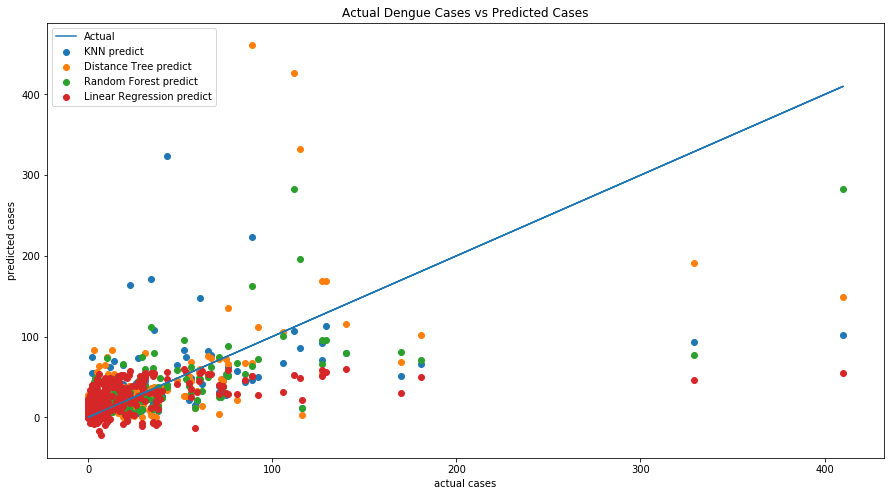

In [234]:
# predicted value from KNN model
knn_reg = KNeighborsRegressor(n_neighbors = best_neighbor.get('n_neighbors'))
knn_fit = knn_reg.fit(np.array(opti_train_features), train_outcome_small)
knn_pred = knn_fit.predict(np.array(opti_vali_features))

# predicted value from Decision Tree model
dt = DecisionTreeRegressor(max_depth = best_depth.get('max_depth'))
dt_fit = dt.fit(np.array(opti_train_features), train_outcome_small)
dt_pred = dt_fit.predict(np.array(opti_vali_features))

# predicted value from Random Forest model
rf = RandomForestRegressor(max_depth = best_depth_ran.get('max_depth'))
rf_fit = rf.fit(np.array(opti_train_features), train_outcome_small)
rf_pred = rf_fit.predict(np.array(opti_vali_features))

# predicted value from Linear Regression model
lm = LinearRegression(fit_intercept = best_param.get('fit_intercept'))
lm_fit = lm.fit(np.array(opti_train_features), train_outcome_small)
lm_pred = lm_fit.predict(np.array(opti_vali_features))

# scatter plot (actual vs predicted)
plt.figure(figsize=(15,8))
plt.plot(validation_outcome, validation_outcome, label = 'Actual')
plt.scatter(validation_outcome, knn_pred, label = 'KNN predict')
plt.scatter(validation_outcome, dt_pred, label = 'Distance Tree predict')
plt.scatter(validation_outcome, rf_pred, label = 'Random Forest predict')
plt.scatter(validation_outcome, lm_pred, label = 'Linear Regression predict')
plt.title('Actual Dengue Cases vs Predicted Cases')
plt.xlabel('actual cases')
plt.ylabel('predicted cases')
plt.legend()
plt.show()

We used residual plot to see if the differences between actual value and predicted value are evenly distributed.

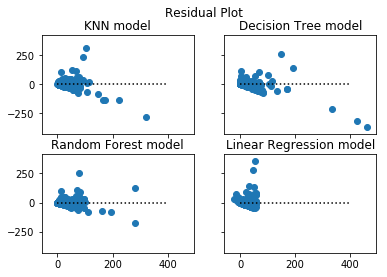

In [235]:
# residual plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
ax1.scatter(knn_pred, validation_outcome - knn_pred)
ax1.hlines(y = 0, xmin = 0, xmax = 400, linestyle = ':')
ax1.set_title('KNN model')
ax2.scatter(dt_pred, validation_outcome - dt_pred)
ax2.hlines(y = 0, xmin = 0, xmax = 400, linestyle = ':')
ax2.set_title('Decision Tree model')
ax3.scatter(rf_pred, validation_outcome - rf_pred)
ax3.hlines(y = 0, xmin = 0, xmax = 400, linestyle = ':')
ax3.set_title('Random Forest model')
ax4.scatter(lm_pred, validation_outcome - lm_pred)
ax4.hlines(y = 0, xmin = 0, xmax = 400, linestyle = ':')
ax4.set_title('Linear Regression model')
plt.suptitle('Residual Plot')
plt.show()

Among these four models, we could see that Random Forest has the highest accuracy. In the scatter plot, the predicted values from Random Forest model are the cloest to the actual values. In the residual plot, the difference between actual values and predicted values are evenly distributed. Therefore, we concluded that **the best model among these four models are Random Forest.** We would use this model to predict the outcome.

In [236]:
# use the whole training set to normalize training and test set
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(dengue_data.values)
train_features_scaled = scaler.transform(dengue_data.values)
test_features_scaled = scaler.transform(test_features.values)

#  get the best 15 features for training scaled set and test scaled set
train_scaled_df = pd.DataFrame(columns = features, data = train_features_scaled)
test_scaled_df = pd.DataFrame(columns = features, data = test_features_scaled)
opti_train_features = pd.DataFrame()
for i in best_features:
    opti_train_features = pd.concat([opti_train_features, train_scaled_df[i]], axis=1, sort=False)
opti_test_features = pd.DataFrame()
for i in best_features:
    opti_test_features = pd.concat([opti_test_features, test_scaled_df[i]], axis=1, sort=False)

# predict the number of dengue cases in test set
rf_test = RandomForestRegressor(max_depth = best_depth_ran.get('max_depth'))
rf_test_fit = rf_test.fit(np.array(opti_train_features), dengue_cases.values)
rf_pred = rf_test_fit.predict(np.array(opti_test_features))
test_pred = [int(round(x)) for x in rf_pred]

In [237]:
# make submission
submission = pd.read_csv('data/submission_format.csv')
submission['total_cases'] = test_pred
submission.to_csv('submission.csv', index = False)